In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
import seaborn as sns

disease types are folder names for importing the data

In [2]:
disease_types = ['Pepper_Bacterial','Pepper_healthy','Potato_Early_blight','Potato_healthy','Potato_Late_blight','Tomato_Bacterial',
                'Tomato_Curl_Virus','Tomato_Early_blight','Tomato_healthy','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_mosaic',
                'Tomato_Septoria_leaf_spot','Tomato_spider_mite','Tomato_Target_Spot']
data_dir = '/Users/michaellaraglione/Documents/GitHub/Capstone3/PlantVillage/'
train_dir = os.path.join(data_dir)

importing the data and turning it into a pandas dataset. Then, randomizing the dataset.

In [3]:
train_data = []
for diseases, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), diseases, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'Disease_ID','Disease_Type'])
train.head(5)

,File,Disease_ID,Disease_Type
0,Pepper_Bacterial/47fbd17d-c078-4465-8816-c675a...,0,Pepper_Bacterial
1,Pepper_Bacterial/42ef264d-f255-4674-885a-0921a...,0,Pepper_Bacterial
2,Pepper_Bacterial/435993b8-c7f7-47fd-85ad-bdb04...,0,Pepper_Bacterial
3,Pepper_Bacterial/1fca0f2b-857b-4cef-9218-42b1b...,0,Pepper_Bacterial
4,Pepper_Bacterial/9cee73cb-272f-4121-b82d-c8c2b...,0,Pepper_Bacterial


In [4]:
data = ImageFolder("PlantVillage/", transform=transforms.ToTensor())
print('Data size: ',len(data))
data.classes

count = {}

for i in range(len(data)):
    _, labels = data[i]
    label = disease_types[labels]
    if label not in count:
        count[label] = 1
    elif label in count:
        count[label] += 1

df = pd.DataFrame(count, index=np.arange(1))
df = df.transpose().reset_index()
df.columns = ['Label', 'count']
df

Data size:  20638


,Label,count
0,Pepper_Bacterial,997
1,Pepper_healthy,1478
2,Potato_Early_blight,1000
3,Potato_healthy,1000
4,Potato_Late_blight,152
5,Tomato_Bacterial,2127
6,Tomato_Curl_Virus,3208
7,Tomato_Early_blight,1000
8,Tomato_healthy,1909
9,Tomato_Late_blight,952


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

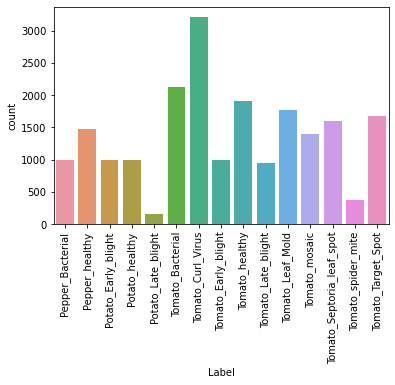

In [5]:
sns.barplot(df['Label'],df['count'])
plt.xticks(rotation=90)

potato late blight and tomato spidermite might be difficult to identify due to the lack of images.

In [6]:
seed = 42
train = train.sample(frac=1, random_state = seed)
train_index = np.arange(len(train)) #to reset the indices
train.head()

,File,Disease_ID,Disease_Type
20045,Tomato_Target_Spot/10e35abb-b0a4-4aa2-a533-ab1...,14,Tomato_Target_Spot
3024,Potato_Early_blight/e6693b54-623a-4323-aa79-3e...,2,Potato_Early_blight
12116,Tomato_healthy/5b2457f5-96d5-4bcd-8025-dc55e66...,8,Tomato_healthy
20483,Tomato_Target_Spot/9d6a295a-f083-49df-875d-d1a...,14,Tomato_Target_Spot
9814,Tomato_Curl_Virus/2e1a7008-0506-4fc1-be60-bbae...,6,Tomato_Curl_Virus


I want to save 5 photos for testing at the end, since I don't want to test using an image used in building or validating the model. 

In [7]:
sampleset = train.head(5)
sampleset

,File,Disease_ID,Disease_Type
20045,Tomato_Target_Spot/10e35abb-b0a4-4aa2-a533-ab1...,14,Tomato_Target_Spot
3024,Potato_Early_blight/e6693b54-623a-4323-aa79-3e...,2,Potato_Early_blight
12116,Tomato_healthy/5b2457f5-96d5-4bcd-8025-dc55e66...,8,Tomato_healthy
20483,Tomato_Target_Spot/9d6a295a-f083-49df-875d-d1a...,14,Tomato_Target_Spot
9814,Tomato_Curl_Virus/2e1a7008-0506-4fc1-be60-bbae...,6,Tomato_Curl_Virus


This is removing the 5 images from the dataset.

In [8]:
train = train.iloc[5:]

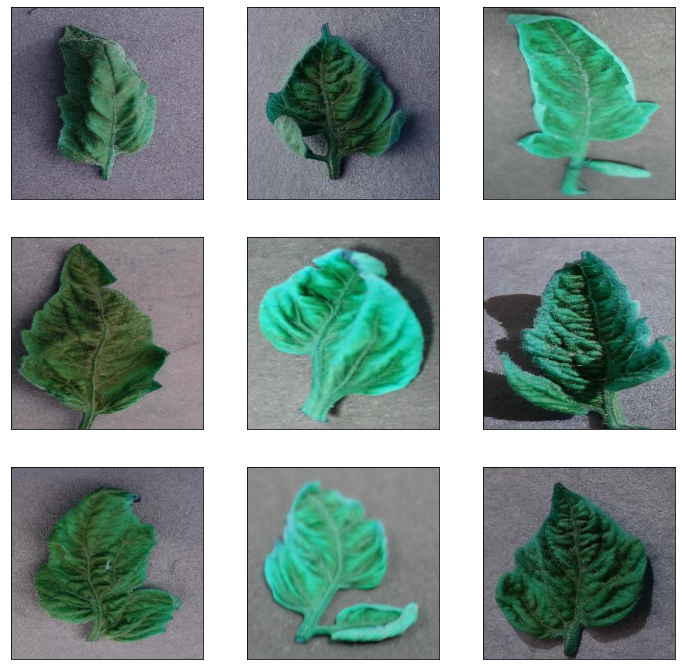

In [9]:
def disease_type(disease_type, rows, cols):
    fig,ax = plt.subplots(rows, cols, figsize=(12,12))
    disease_type = train['File'][train['Disease_Type'] == disease_type].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, disease_type[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
disease_type('Tomato_Curl_Virus', 3, 3)

split into train and validate 

In [10]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split = 0.2)
validation_generator = datagen.flow_from_directory(
    data_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb",
    class_mode="categorical")

train_generator = datagen.flow_from_directory(
    data_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical")

Found 20638 images belonging to 15 classes.
Found 16516 images belonging to 15 classes.


building the model: LeNet was used to develop the model. Using a kernel size of (3,3) was too small. By increasing to (5,5) the model performed better. 

In [11]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(256,256,3)),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters=20, kernel_size=(5, 5), activation='relu'),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=120, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=84, activation='relu'),
    keras.layers.Dense(units=15, activation = 'softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 126, 126, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 20)      3020      
_________________________________________________________________
average_pooling2d_1 (Average (None, 61, 61, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 74420)             0         
_________________________________________________________________
dropout (Dropout)            (None, 74420)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               8

In [12]:
batch_size = 32
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_generator, batch_size=batch_size, epochs=epochs, validation_data=validation_generator)

Epoch 1/15
517/517 [==============================] - 305s 589ms/step - loss: 2.7554 - accuracy: 0.2359 - val_loss: 1.3096 - val_accuracy: 0.5890
Epoch 2/15
517/517 [==============================] - 302s 585ms/step - loss: 1.3968 - accuracy: 0.5546 - val_loss: 0.9062 - val_accuracy: 0.6959
Epoch 3/15
517/517 [==============================] - 306s 592ms/step - loss: 0.9664 - accuracy: 0.6786 - val_loss: 0.5850 - val_accuracy: 0.8168
Epoch 4/15
517/517 [==============================] - 303s 585ms/step - loss: 0.7268 - accuracy: 0.7566 - val_loss: 0.5174 - val_accuracy: 0.8404
Epoch 5/15
517/517 [==============================] - 307s 594ms/step - loss: 0.5366 - accuracy: 0.8224 - val_loss: 0.4126 - val_accuracy: 0.8763
Epoch 6/15
517/517 [==============================] - 318s 616ms/step - loss: 0.4528 - accuracy: 0.8502 - val_loss: 0.3186 - val_accuracy: 0.9084
Epoch 7/15
517/517 [==============================] - 314s 607ms/step - loss: 0.3433 - accuracy: 0.8866 - val_loss: 0.3361 -

below shows the Validation and training accuracy at each epoch. 

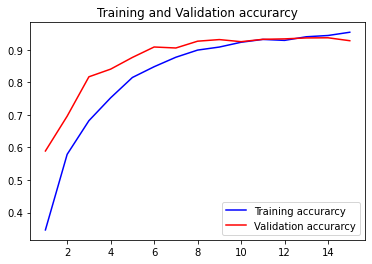

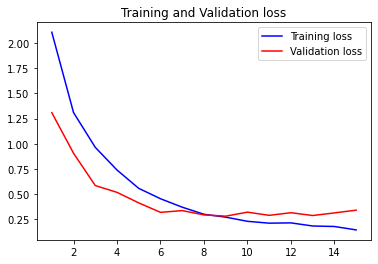

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
preds = model.predict_generator(validation_generator, steps=5)
label = validation_generator.classes
pred = model.predict(validation_generator)

predicted_class_indices=np.argmax(pred,axis=1)

/Users/michaellaraglione/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [16]:
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]


In [17]:
sampleset

,File,Disease_ID,Disease_Type
20045,Tomato_Target_Spot/10e35abb-b0a4-4aa2-a533-ab1...,14,Tomato_Target_Spot
3024,Potato_Early_blight/e6693b54-623a-4323-aa79-3e...,2,Potato_Early_blight
12116,Tomato_healthy/5b2457f5-96d5-4bcd-8025-dc55e66...,8,Tomato_healthy
20483,Tomato_Target_Spot/9d6a295a-f083-49df-875d-d1a...,14,Tomato_Target_Spot
9814,Tomato_Curl_Virus/2e1a7008-0506-4fc1-be60-bbae...,6,Tomato_Curl_Virus


In [18]:
sample1 = data_dir + sampleset['File'].iloc[0]
sample2 = data_dir + sampleset['File'].iloc[1]
sample3 = data_dir + sampleset['File'].iloc[2]
sample4 = data_dir + sampleset['File'].iloc[3]
sample5 = data_dir + sampleset['File'].iloc[4]

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

cf_report = classification_report(predicted_class_indices,label)
cm = confusion_matrix(predicted_class_indices,label)

print(cf_report)


              precision    recall  f1-score   support

           0       0.91      0.95      0.93       952
           1       0.96      0.92      0.94      1552
           2       0.97      0.95      0.96      1020
           3       0.89      0.92      0.91       970
           4       0.80      0.94      0.87       130
           5       0.94      0.93      0.93      2161
           6       0.97      0.98      0.97      3190
           7       0.85      0.88      0.87       971
           8       0.94      0.88      0.91      2036
           9       0.92      0.92      0.92       946
          10       0.84      0.92      0.88      1614
          11       0.92      0.86      0.89      1504
          12       0.96      0.95      0.95      1608
          13       0.88      0.97      0.92       340
          14       0.93      0.95      0.94      1644

    accuracy                           0.93     20638
   macro avg       0.91      0.93      0.92     20638
weighted avg       0.93   

Text(0.5, 185.99374999999995, 'Predicted')

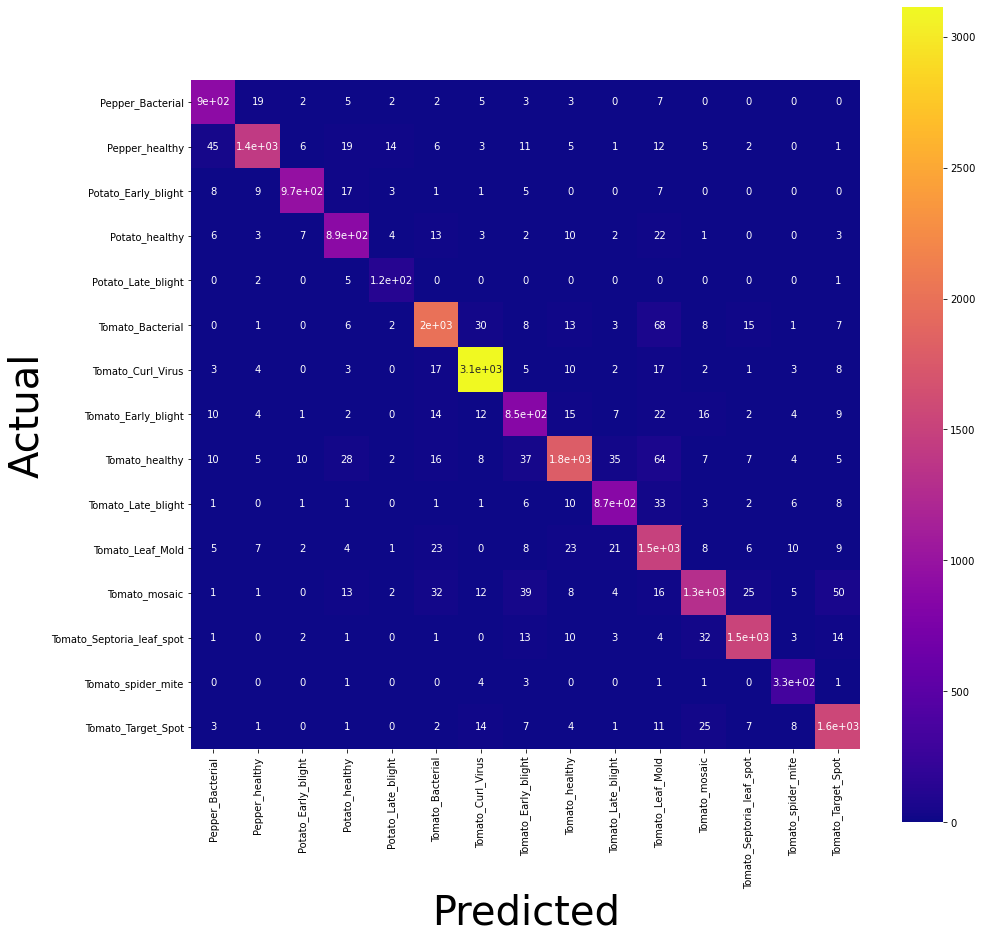

In [20]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(cm, cmap=plt.cm.plasma, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)

ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [21]:
image = tf.keras.preprocessing.image.load_img(sample1)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
preds1 = model.predict_classes(input_arr)

image = tf.keras.preprocessing.image.load_img(sample2)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
preds2 = model.predict_classes(input_arr)

image = tf.keras.preprocessing.image.load_img(sample3)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
preds3 = model.predict_classes(input_arr)

image = tf.keras.preprocessing.image.load_img(sample4)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
preds4 = model.predict_classes(input_arr)

image = tf.keras.preprocessing.image.load_img(sample5)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
preds5 = model.predict_classes(input_arr)

/Users/michaellaraglione/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [22]:
print(preds1, preds2, preds3, preds4, preds5)

[14] [2] [12] [11] [6]


In [23]:
print(disease_types[14],disease_types[2], disease_types[12],disease_types[10],disease_types[6])

Tomato_Target_Spot Potato_Early_blight Tomato_Septoria_leaf_spot Tomato_Leaf_Mold Tomato_Curl_Virus


In [24]:
sampleset

,File,Disease_ID,Disease_Type
20045,Tomato_Target_Spot/10e35abb-b0a4-4aa2-a533-ab1...,14,Tomato_Target_Spot
3024,Potato_Early_blight/e6693b54-623a-4323-aa79-3e...,2,Potato_Early_blight
12116,Tomato_healthy/5b2457f5-96d5-4bcd-8025-dc55e66...,8,Tomato_healthy
20483,Tomato_Target_Spot/9d6a295a-f083-49df-875d-d1a...,14,Tomato_Target_Spot
9814,Tomato_Curl_Virus/2e1a7008-0506-4fc1-be60-bbae...,6,Tomato_Curl_Virus
